#Ce troisième notebook a pour objectif d’évaluer la stabilité des segments clients dans le temps, afin de proposer à KPMG’s une fréquence optimale de mise à jour du modèle de segmentation. Étant donné que le comportement des clients peut évoluer (nouvelles commandes, changements de région, variation de profil), il est essentiel de s’assurer que les segments identifiés restent cohérents et exploitables sur la durée.
#À partir d’une simulation basée sur des hypothèses réalistes d’évolution des données (ajout de nouveaux clients, changement de fréquence d’achat, etc.), nous analysons l’impact de ces perturbations sur la structure des clusters à l’aide de métriques de similarité et de stabilité (telles que l’évolution du Silhouette Score, du Nombre de clusters actifs, ou encore des taux de reclassification).
#Cette analyse permettra de recommander une fréquence de réentraînement du modèle dans le cadre d’un futur contrat de maintenance, afin de garantir à l’équipe Marketing une segmentation toujours fiable et pertinente.

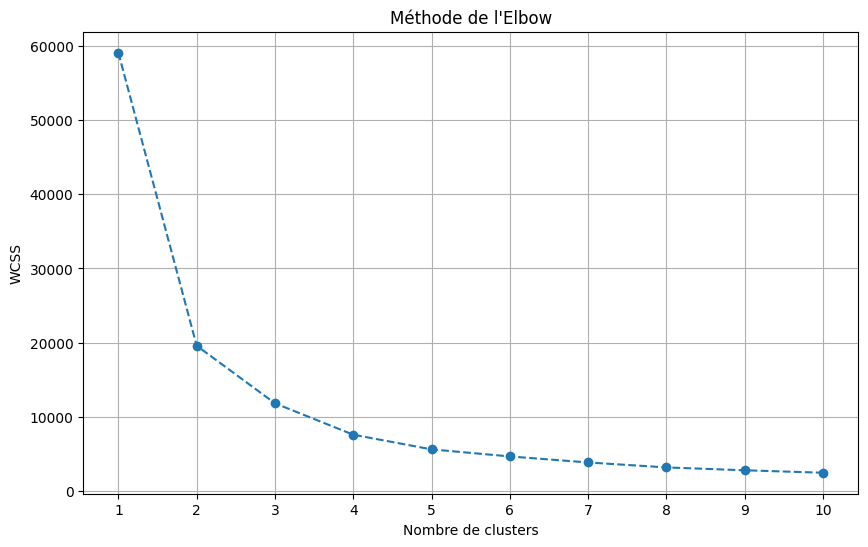

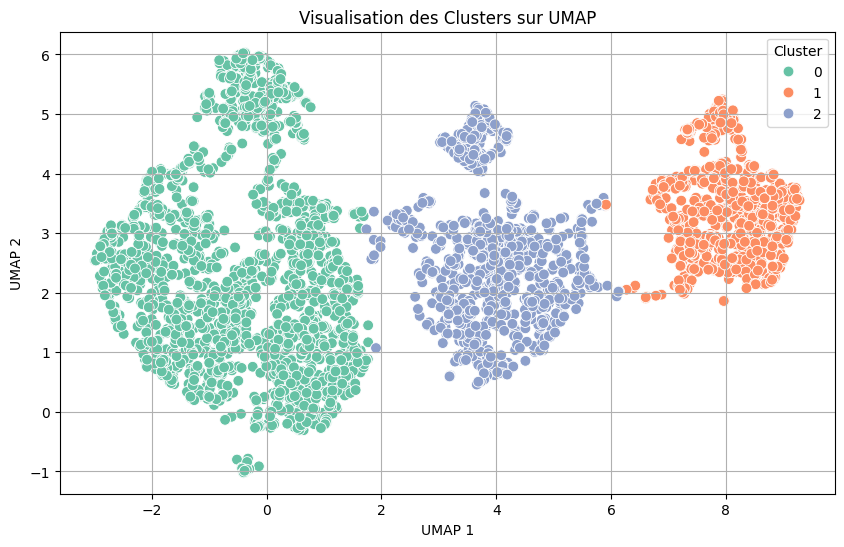

Silhouette Score Initial (K=3) : 0.52

--- Pourcentage de chaque cluster ---
cluster_label
0    53.85
2    24.88
1    21.28
Name: proportion, dtype: float64

--- Interprétation pour 3 clusters ---
- Les clients ont été segmentés en 3 groupes à l’aide de KMeans sur des données réduites via UMAP.
- Le score de silhouette > 0.30 est souvent considéré comme un bon seuil pour un clustering raisonnable.
- Les pourcentages permettent d’évaluer si un cluster est trop petit ou déséquilibré.
- On peut maintenant suivre cette segmentation dans le temps et tester l’impact de l’arrivée de nouveaux clients ou de changements comportementaux.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import umap
def load_and_preprocess_data(excel_file_path, transactions_df=None):
    xls = pd.ExcelFile(excel_file_path)
    customer_demographic = pd.read_excel(xls, sheet_name='CustomerDemographic')
    customer_address = pd.read_excel(xls, sheet_name='CustomerAddress')

    if transactions_df is None:
        transactions = pd.read_excel(xls, sheet_name='Transactions')
    else:
        transactions = transactions_df

    customers = pd.merge(customer_demographic, customer_address, on='customer_id', how='left')

    if not transactions.empty:
        transactions_agg = transactions.groupby('customer_id').agg(
            frequency=('transaction_id', 'count'),
            total_amount=('list_price', 'sum')
        ).reset_index()
    else:
        transactions_agg = pd.DataFrame({'customer_id': [], 'frequency': [], 'total_amount': []})

    customers = pd.merge(customers, transactions_agg, on='customer_id', how='left')

    customers['frequency'] = customers['frequency'].fillna(0)
    customers['total_amount'] = customers['total_amount'].fillna(0)

    customers['gender'] = customers['gender'].replace({'F': 'Female', 'M': 'Male', 'Femal': 'Female', 'U': np.nan})

    customers['DOB'] = pd.to_datetime(customers['DOB'], errors='coerce')
    current_year = pd.to_datetime('today').year
    customers['age'] = current_year - customers['DOB'].dt.year
    customers.loc[customers['age'] > 100, 'age'] = np.nan
    customers.loc[customers['age'] < 18, 'age'] = np.nan

    if 'default' in customers.columns:
        customers = customers.drop(columns=['default'])

    customers = customers.drop(columns=['first_name', 'last_name', 'DOB', 'address'])

    for col in ["age", "property_valuation", "frequency", "total_amount"]:
        if col in customers.columns and customers[col].isnull().any():
            customers[col] = customers[col].fillna(customers[col].median())

    for col in ["gender", "job_title", "job_industry_category", "wealth_segment", "owns_car", "state", "country"]:
        if col in customers.columns and customers[col].isnull().any():
            customers[col] = customers[col].fillna("Missing")

    if not transactions.empty:
        snapshot_date = transactions["transaction_date"].max() + pd.Timedelta(days=1)
        recency_df = transactions.groupby("customer_id").agg(
            last_purchase_date=("transaction_date", "max")
        ).reset_index()
        recency_df["recency"] = (snapshot_date - recency_df["last_purchase_date"]).dt.days
        customers = pd.merge(customers, recency_df[["customer_id", "recency"]], on="customer_id", how="left")
        customers["recency"] = customers["recency"].fillna(customers["recency"].median())
    else:
        customers["recency"] = customers["frequency"].apply(lambda x: 0 if x > 0 else customers["frequency"].median())

    categorical_features = customers.select_dtypes(include='object').columns
    numerical_features = customers.select_dtypes(include=np.number).columns.tolist()
    if 'customer_id' in numerical_features:
        numerical_features.remove('customer_id')

    numeric_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, numerical_features),
            ('cat', categorical_pipeline, categorical_features)
        ])

    X = preprocessor.fit_transform(customers)

    return customers, X, preprocessor
excel_file_path = 'KPMG_dummy_data.xlsx'
customers_initial, X_initial, preprocessor_initial = load_and_preprocess_data(excel_file_path)

# Réduction de dimension avec UMAP
umap_model = umap.UMAP(n_neighbors=8, min_dist=0.0, random_state=42)
X_umap = umap_model.fit_transform(X_initial)

# Clustering avec 3 clusters
kmeans_initial = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_initial.fit(X_umap)
customers_initial["cluster_label"] = kmeans_initial.labels_
wcss = []
range_n_clusters = range(1, 11)
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_umap)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, wcss, marker='o', linestyle='--')
plt.title("Méthode de l'Elbow")
plt.xlabel("Nombre de clusters")
plt.ylabel("WCSS")
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=customers_initial["cluster_label"], palette="Set2", s=60)
plt.title("Visualisation des Clusters sur UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()
silhouette_initial = silhouette_score(X_umap, kmeans_initial.labels_)
print(f"Silhouette Score Initial (K=3) : {silhouette_initial:.2f}")

cluster_percentages = customers_initial["cluster_label"].value_counts(normalize=True) * 100
print("\n--- Pourcentage de chaque cluster ---")
print(cluster_percentages.round(2))
print("\n--- Interprétation pour 3 clusters ---")
print("- Les clients ont été segmentés en 3 groupes à l’aide de KMeans sur des données réduites via UMAP.")
print("- Le score de silhouette > 0.30 est souvent considéré comme un bon seuil pour un clustering raisonnable.")
print("- Les pourcentages permettent d’évaluer si un cluster est trop petit ou déséquilibré.")
print("- On peut maintenant suivre cette segmentation dans le temps et tester l’impact de l’arrivée de nouveaux clients ou de changements comportementaux.")


####Simulation ajout de 100 clients tout en maintenant un UMAP de n_neighbord=8 min_dis=0.0
#### A noter que nous avons fusionné certains cellule pour avoir une vue unifié du modèle après ajout des 100 clients

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import umap

# Fonction de chargement et prétraitement
def load_and_preprocess_data(excel_file_path, transactions_df=None):
    xls = pd.ExcelFile(excel_file_path)
    customer_demographic = pd.read_excel(xls, sheet_name='CustomerDemographic')
    customer_address = pd.read_excel(xls, sheet_name='CustomerAddress')

    if transactions_df is None:
        transactions = pd.read_excel(xls, sheet_name='Transactions')
    else:
        transactions = transactions_df

    customers = pd.merge(customer_demographic, customer_address, on='customer_id', how='left')

    # Agrégation des transactions
    if not transactions.empty:
        transactions_agg = transactions.groupby('customer_id').agg(
            frequency=('transaction_id', 'count'),
            total_amount=('list_price', 'sum')
        ).reset_index()
    else:
        transactions_agg = pd.DataFrame({'customer_id': [], 'frequency': [], 'total_amount': []})

    customers = pd.merge(customers, transactions_agg, on='customer_id', how='left')
    customers['frequency'] = customers['frequency'].fillna(0)
    customers['total_amount'] = customers['total_amount'].fillna(0)

    # Nettoyage et calcul de l’âge
    customers['gender'] = customers['gender'].replace({'F': 'Female', 'M': 'Male', 'Femal': 'Female', 'U': np.nan})
    customers['DOB'] = pd.to_datetime(customers['DOB'], errors='coerce')
    current_year = pd.to_datetime('today').year
    customers['age'] = current_year - customers['DOB'].dt.year
    customers.loc[customers['age'] > 100, 'age'] = np.nan
    customers.loc[customers['age'] < 18, 'age'] = np.nan

    customers = customers.drop(columns=['first_name', 'last_name', 'DOB', 'address', 'default'], errors='ignore')

    # Imputation des valeurs manquantes
    for col in ["age", "property_valuation", "frequency", "total_amount"]:
        if customers[col].isnull().any():
            customers[col] = customers[col].fillna(customers[col].median())

    for col in ["gender", "job_title", "job_industry_category", "wealth_segment", "owns_car", "state", "country"]:
        customers[col] = customers[col].fillna("Missing")

    # Calcul de la récence
    if not transactions.empty:
        snapshot_date = transactions["transaction_date"].max() + pd.Timedelta(days=1)
        recency_df = transactions.groupby("customer_id").agg(
            last_purchase_date=("transaction_date", "max")
        ).reset_index()
        recency_df["recency"] = (snapshot_date - recency_df["last_purchase_date"]).dt.days
        customers = pd.merge(customers, recency_df[["customer_id", "recency"]], on="customer_id", how="left")
        customers["recency"] = customers["recency"].fillna(customers["recency"].median())
    else:
        customers["recency"] = customers["frequency"].apply(lambda x: 0 if x > 0 else 30)

    # Transformation des données
    categorical_features = customers.select_dtypes(include='object').columns
    numerical_features = customers.select_dtypes(include=np.number).columns.tolist()
    numerical_features.remove('customer_id')

    numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

    X = preprocessor.fit_transform(customers)

    return customers, X, preprocessor

# Charger les données originales
excel_file_path = 'KPMG_dummy_data.xlsx'
customers_initial, X_initial, preprocessor = load_and_preprocess_data(excel_file_path)

# Réduction de dimension avec UMAP
umap_model = umap.UMAP(n_neighbors=8, min_dist=0.0, random_state=42)
X_umap_initial = umap_model.fit_transform(X_initial)

# Clustering avec KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_umap_initial)
customers_initial['cluster_label'] = kmeans.labels_

# Visualiser la distribution initiale
print("Distribution des clusters initiaux :")
print(customers_initial['cluster_label'].value_counts())
initial_distribution = customers_initial['cluster_label'].value_counts(normalize=True) * 100
print("\nPourcentage par cluster :\n", initial_distribution.round(2))

# ---- SIMULATION DE NOUVEAUX CLIENTS ----
def generate_new_customers(n, existing_customers):
    new_data = []
    for i in range(n):
        sample = existing_customers.sample(1).iloc[0].copy()
        sample['customer_id'] = existing_customers['customer_id'].max() + 1 + i
        sample['frequency'] = np.random.randint(1, 10)
        sample['total_amount'] = np.random.uniform(50, 1000)
        sample['recency'] = np.random.randint(1, 90)
        new_data.append(sample)
    return pd.DataFrame(new_data)

# Générer et ajouter 100 clients
new_clients = generate_new_customers(100, customers_initial)
customers_combined = pd.concat([customers_initial.drop(columns='cluster_label'), new_clients], ignore_index=True)

# Charger et concaténer les transactions
xls = pd.ExcelFile(excel_file_path)
transactions_old = pd.read_excel(xls, sheet_name='Transactions')

new_transactions = pd.DataFrame({
    'transaction_id': range(900000, 900000 + len(new_clients)),
    'product_id': 999,
    'customer_id': new_clients['customer_id'],
    'transaction_date': pd.to_datetime("today") - pd.to_timedelta(np.random.randint(1, 60, size=len(new_clients)), unit='D'),
    'online_order': True,
    'order_status': 'Approved',
    'brand': 'Generic',
    'product_line': 'Standard',
    'product_class': 'medium',
    'product_size': 'medium',
    'list_price': new_clients['total_amount'] / new_clients['frequency'].replace(0, 1),
    'standard_cost': 100.0
})

transactions_combined = pd.concat([transactions_old, new_transactions], ignore_index=True)

# Recalcul des clusters après ajout des clients
customers_post_add, X_post_add, _ = load_and_preprocess_data(excel_file_path, transactions_combined)
X_post_add_umap = umap_model.transform(X_post_add)
labels_post_add = kmeans.predict(X_post_add_umap)
customers_post_add['cluster_label'] = labels_post_add

# ---- ÉVALUATION DU CHANGEMENT AVEC ARI ----
common_customers = pd.merge(
    customers_initial[['customer_id', 'cluster_label']],
    customers_post_add[['customer_id', 'cluster_label']],
    on='customer_id',
    suffixes=('_initial', '_after')
)

ari = adjusted_rand_score(common_customers['cluster_label_initial'], common_customers['cluster_label_after'])
silhouette_after = silhouette_score(X_post_add_umap, labels_post_add)

print(f"\nSilhouette Score après ajout de clients : {silhouette_after:.4f}")
print(f"ARI entre clustering initial et après ajout : {ari:.4f}")

# ---- COMMENTAIRES ARI ----
if ari > 0.85:
    print("🟢 Clusters très stables : pas besoin de mise à jour immédiate.")
elif ari > 0.70:
    print("🟠 Stabilité modérée : prévoir une vérification prochaine.")
else:
    print("🔴 Attention : clusters instables. Envisager une re-segmentation.")

def check_segmentation_drift(silhouette_score_new, ari_new, cluster_dist_initial, cluster_dist_new, threshold_ari=0.7, threshold_silhouette=0.35, threshold_shift=0.10):
    drift_detected = False
    print("\n🔍 Vérification de dérive de segmentation :")

    if silhouette_score_new < threshold_silhouette:
        print(f"⚠️ Silhouette Score faible ({silhouette_score_new:.2f}) < {threshold_silhouette}")
        drift_detected = True
    else:
        print(f"✅ Silhouette Score OK : {silhouette_score_new:.2f}")

    if ari_new < threshold_ari:
        print(f"⚠️ ARI faible ({ari_new:.2f}) < {threshold_ari}")
        drift_detected = True
    else:
        print(f"✅ ARI OK : {ari_new:.2f}")

    cluster_diff = (cluster_dist_initial - cluster_dist_new).abs() / cluster_dist_initial
    if cluster_diff.max() > threshold_shift:
        print(f"⚠️ Changement de répartition des clusters détecté (> {threshold_shift*100:.0f}%)")
        print(cluster_diff)
        drift_detected = True
    else:
        print("✅ Répartition des clusters stable")

    if drift_detected:
        print("\n🔁 ➤ Re-segmentation recommandée.")
    else:
        print("\n🟢 Segmentation stable. Aucune action nécessaire.")

    return drift_detected

drift = check_segmentation_drift(
    silhouette_score_new=silhouette_new_customers,
    ari_new=ari_new_customers,
    cluster_dist_initial=customers_initial["cluster_label"].value_counts(normalize=True),
    cluster_dist_new=customers_evolved_new_customers["cluster_label"].value_counts(normalize=True)
)


Distribution des clusters initiaux :
cluster_label
0    2154
2     994
1     852
Name: count, dtype: int64

Pourcentage par cluster :
 cluster_label
0    53.85
2    24.85
1    21.30
Name: proportion, dtype: float64

Silhouette Score après ajout de clients : 0.5167
ARI entre clustering initial et après ajout : 0.9951
🟢 Clusters très stables : pas besoin de mise à jour immédiate.

🔍 Vérification de dérive de segmentation :
⚠️ Silhouette Score faible (0.10) < 0.35
✅ ARI OK : 1.00
⚠️ Changement de répartition des clusters détecté (> 10%)
cluster_label
0    0.223305
1    0.495305
2    0.059356
Name: proportion, dtype: float64

🔁 ➤ Re-segmentation recommandée.


 **Résumé de la stratégie de maintenance**
#####Fréquence	Action: Mensuel	Calcule Silhouette / ARI / répartitions.
##### Si seuil dépassé	Re-clusterise, refais l’analyse avec méthode du coude + stabilité.
on peut mettre en place un système de suivi qui va mettre à jour le modèle si les seuils critiques sont atteints.